In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl

# Collecting Data to Analysis

<Axes: >

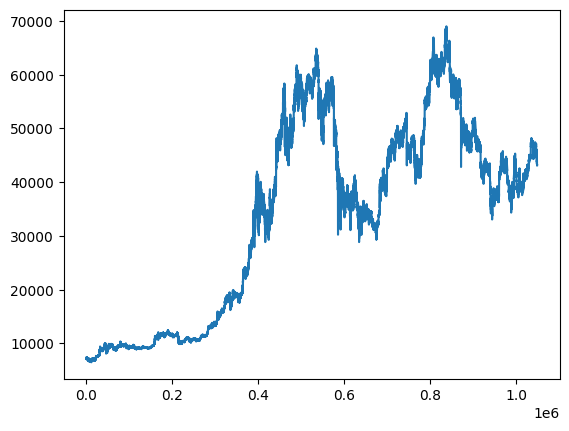

In [11]:
df = pd.read_parquet('../data/cryptos/BTCUSD_2020-04-07_2022-04-06.parquet', engine = 'pyarrow')
df.CLOSE.plot()

# Old Fractional Diff

In [12]:
def _get_weight_ffd(d, thres, lim):
    w, k = [1.], 1
    ctr = 0
    while True:
        w_ = -w[-1] / k * (d - k + 1)
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
        ctr += 1
        if ctr == lim - 1:
            break
    w = np.array(w[::-1]).reshape(-1, 1)
    return w


def frac_diff_ffd(x, d, thres=1e-5, disable_warning=False):
    if np.max(x) > 10.0 and not disable_warning:
        print('WARNING: have you applied log before calling this function? If yes, discard this warning.')
    w = _get_weight_ffd(d, thres, len(x))
    width = len(w) - 1
    output = []
    output.extend([0] * width)
    for i in range(width, len(x)):
        output.append(np.dot(w.T, x[i - width:i + 1])[0])
    return np.array(output) 

In [65]:
def plot_multi(data, cols=None, spacing=.1, **kwargs):
    # Get default color style from pandas - can be changed to any other color list
    if cols is None:
        cols = data.columns
    if len(cols) == 0:
        return
    colors = ['r', 'b', 'g']

    # First axis
    ax = data[cols[0]].plot(label=cols[0], color=colors[0], **kwargs)
    ax.set_ylabel(ylabel=cols[0])
    lines, labels = ax.get_legend_handles_labels()

    for n in range(1, len(cols)):
        # Multiple y-axes
        ax_new = ax.twinx()
        ax_new.spines['right'].set_position(('axes', 1 + spacing * (n - 1)))
        data[cols[n]].plot(ax=ax_new, label=cols[n], color=colors[n % len(colors)])
        ax_new.set_ylabel(ylabel=cols[n])

        # Proper legend position
        line, label = ax_new.get_legend_handles_labels()
        lines += line
        labels += label
  
    ax.legend(lines, labels, loc=0)
    return ax

            CLOSE  Fractional differentiation FFD
1048685  43144.08                        0.385624
1048686  43188.59                        0.386871
1048687  43111.80                        0.384824
1048688  43149.90                        0.386407
1048689  43173.96                        0.386850


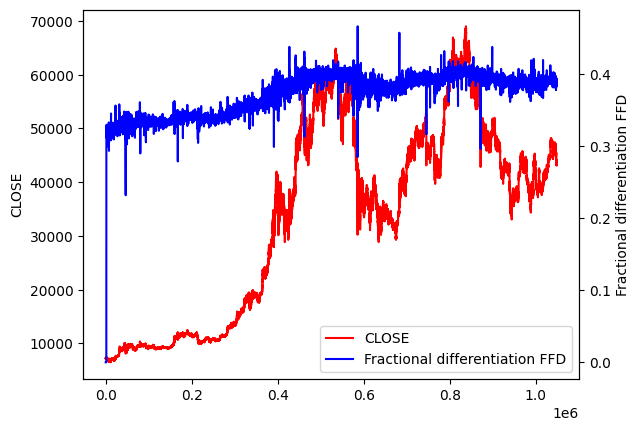

In [66]:
fractional_returns = frac_diff_ffd(df['CLOSE'].apply(np.log).values, d=0.4)
df['Fractional differentiation FFD'] = fractional_returns
df = df[['CLOSE', 'Fractional differentiation FFD']]
print(df.tail())
plot_multi(df)
plt.show()

# New Contributions

In [61]:
from statsmodels.tsa.stattools import adfuller, kpss


In [159]:
def frac_diff(series, d, threshold=1e-5, window_max_size = 100):
    """
    Perform fractional differentiation on a time series.

    Parameters:
    series (pd.Series): The input time series.
    d (float): The fractional order of differentiation.
    threshold (float): The threshold to trim small weights (default 1e-5).
    window_max_size (int): the max size of the weights window
    
    Returns:
    pd.Series: The fractionally differentiated series.
    """
    # Calculate weights using the binomial expansion
    w = [1.0]
    for k in range(1, len(series)):
        w_ = -w[-1] * (d - k + 1) / k
        if abs(w_) < threshold or len(w) > window_max_size:  # Stop if weights are too small or window to big
            break
        w.append(w_)

    # Reverse weights for convolution
    w = np.array(w[::-1]).reshape(-1, 1)

    # Perform fractional differentiation
    df_series = pd.Series(dtype='float64', index=series.index)
    for iloc in range(len(w) - 1, len(series)):
        df_series.iloc[iloc] = np.dot(w.T, series.iloc[iloc - len(w) + 1 : iloc + 1])[0]

    return df_series.dropna()

def frac_integrate(series, d, threshold=1e-5, window_max_size = 100):
    """
    Perform fractional integration on a differentiated time series.

    Parameters:
    series (pd.Series): The input fractionally differentiated series.
    d (float): The fractional order of integration.
    threshold (float): The threshold to trim small weights (default 1e-5).

    Returns:
    pd.Series: The fractionally integrated series.
    """
    # Calculate weights using the binomial expansion (inverse of differentiation weights)
    w = [1.0]
    for k in range(1, len(series)):
        w_ = w[-1] * (d + k - 1) / k
        if abs(w_) < threshold or len(w) > window_max_size:  # Stop if weights are too small or window to big
            break
        w.append(w_)
    
    # Reverse weights for convolution (applied cumulatively for integration)
    w = np.array(w[::-1]).reshape(-1, 1)
    
    # Perform fractional integration
    integrated_series = pd.Series(dtype='float64', index=series.index)
    for iloc in range(len(w) - 1, len(series)):
        x_tmp = np.dot(w.T, series.iloc[iloc - len(w) + 1 : iloc + 1])[0]
        integrated_series.iloc[iloc] = x_tmp
    return integrated_series


In [163]:
def generate_ar_series(n, phi, c=0, sigma=1, seed=None):
    """
    Generate a time series following an AR(p) process.

    Parameters:
    n (int): Length of the time series to generate.
    phi (list of float): List of AR coefficients (length determines p).
    c (float): Constant term in the AR model.
    sigma (float): Standard deviation of the noise term.
    seed (int): Seed for random number generator (for reproducibility).

    Returns:
    pd.Series: Generated AR(p) time series.
    """
    if seed is not None:
        np.random.seed(seed)
    
    p = len(phi)
    series = np.zeros(n)
    noise = np.random.normal(0, sigma, n)  # White noise

    # Generate the AR(p) series
    for t in range(p, n):
        series[t] = c + np.dot(phi, series[t-p:t][::-1]) + noise[t]

    return pd.Series(series)

# Testing d-value for Stationarity

#### Parameters

In [211]:
serie_size = 500
phi = 0.99
d = 1.3
threshold=0.001
window_max_size=100

#### Ground Truth Serie

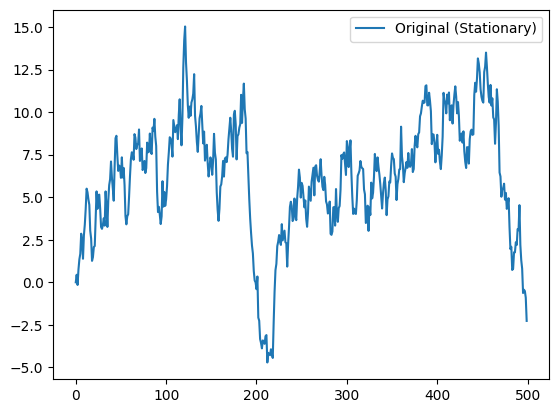

In [212]:
x = generate_ar_series(serie_size, [phi],c=0.1)
x.plot(label="Original (Stationary)")
plt.legend()
plt.show()


#### Frac Integration

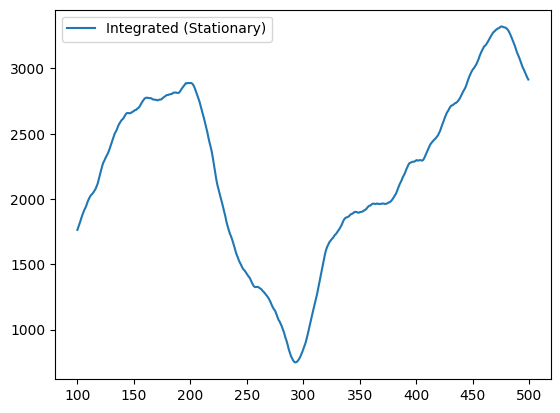

In [219]:
integrated_x = frac_integrate(x,d=d,threshold=threshold, window_max_size=window_max_size)
integrated_x.plot(label="Integrated (Stationary)")
plt.legend()
plt.show()

In [220]:
adf_result = adfuller(integrated_x.dropna())
p_value = adf_result[1]    
if p_value < 0.05:
    print(f"Stationarity achieved with d = {d} (p-value = {p_value})")
else:
    print(f"Not Stationary (p-value = {p_value})")


Not Stationary (p-value = 0.11246224010318273)


#### Frac Diff Steps Until Stationary

In [222]:
for d_test in np.linspace(0.5,2,20):
    diff_integrated_x = frac_diff(integrated_x,d=d_test, threshold=threshold, window_max_size=window_max_size)
    
    adf_result = adfuller(diff_integrated_x.dropna())
    p_value = adf_result[1]    
    if p_value < 0.05:
        print(f"Stationarity achieved with d = {d_test}, real d = {d}(p-value = {p_value})")
        break
    else:
        print(f"Not Stationary with d_test={d_test} (p-value = {p_value})")

Not Stationary with d_test=0.5 (p-value = 0.39803187934094825)
Not Stationary with d_test=0.5789473684210527 (p-value = 0.27520545049092926)
Not Stationary with d_test=0.6578947368421053 (p-value = 0.22762439509821047)
Not Stationary with d_test=0.7368421052631579 (p-value = 0.25646181519679445)
Not Stationary with d_test=0.8157894736842105 (p-value = 0.20207368834853545)
Not Stationary with d_test=0.8947368421052632 (p-value = 0.2679928522204876)
Not Stationary with d_test=0.9736842105263157 (p-value = 0.1489704586023617)
Not Stationary with d_test=1.0526315789473684 (p-value = 0.16148582972329517)
Not Stationary with d_test=1.131578947368421 (p-value = 0.07807684521244074)
Not Stationary with d_test=1.2105263157894737 (p-value = 0.11315348642764139)
Not Stationary with d_test=1.2894736842105263 (p-value = 0.07969036640961596)
Stationarity achieved with d = 1.3684210526315788, real d = 1.3(p-value = 0.042911004097821615)
